<a href="https://colab.research.google.com/github/andreaskuepfer/python-for-social-scientists/blob/main/Day%202/day_2_python_for_social_scientists_SSDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Workshop Day 2: Python for Social Scientists

##### **Social Science Data Lab**
##### **MZES, University of Mannheim**
##### **February 22, 2023**

##### *Andreas Küpfer and Ruben Bach*

Today we want to work with the wage dataset from the *1985 Current Population Survey*. More information on the dataset can be found [here](https://www.openml.org/search?type=data&sort=runs&id=534&status=active).

This workshop is divided into four sections:

1. First, we will to load our dataset into Python and take a look at its specifics.
2. Second, we are going to apply a logistic regression model based on the machine learning library `scikit-learn` for Python.
3. Third, we stick to `scikit-learn` but work with a random forest model.
4. Last but not least we wrap everything up with a short conclusion including an interpretation of the applied models and what further steps could be applied now.

### 1 Load the Dataset & Explore the Data

The following packages are all we need for this workshop:

* `pandas` (https://pandas.pydata.org/docs/)
* `matplotlib` (https://matplotlib.org/)
* `sklearn` (https://scikit-learn.org/stable/)
* `seaborn`: (https://seaborn.pydata.org/)

They can be automatically installed (if not available) using the package manager pip and the following code chunk:

In [ ]:
import importlib.util
import os

# Check for missing packages
def check_pkg(package):
  if importlib.util.find_spec(package):
    return(f"{package} already in sys.modules")
  else:
    os.system("pip install {0}".format(package))
    return(f"{package} installed.")

packages = ["pandas", "matplotlib", "sklearn", "seaborn"]
[check_pkg(package) for package in packages]

['pandas already in sys.modules',
 'matplotlib already in sys.modules',
 'sklearn already in sys.modules',
 'seaborn already in sys.modules',
 'treeinterpreter installed.']

In [ ]:
# Import needed functionalities
from sklearn.datasets import fetch_openml
# Alternative to import all functions from a package:
# import sklearn

# Call fetch_open function to fetch dataset
# Current Population Survey (CPS) from 1985 (random sample of 534 persons)
wages_survey_raw = fetch_openml(data_id=534, as_frame=True)

# A brief overview over all variables in the dataset:
# WAGE: Wage (dollars per hour).
# AGE: Age (years).
# RACE: Race (1=Other, 2=Hispanic, 3=White).
# EDUCATION: Number of years of education.
# SOUTH: Indicator variable for Southern Region (1=Person lives in South, 0=Person lives elsewhere).
# SEX: Indicator variable for sex (1=Female, 0=Male). EXPERIENCE: Number of years of work experience.
# UNION: Indicator variable for union membership (1=Union member, 0=Not union member).
# OCCUPATION: Occupational category (1=Management, 2=Sales, 3=Clerical, 4=Service, 5=Professional, 6=Other).
# SECTOR: Sector (0=Other, 1=Manufacturing, 2=Construction).
# MARR: Marital Status (0=Unmarried, 1=Married)

In [ ]:
# Bring the predictors of the dataset into a suitable format (datframe)
wages_survey_X = wages_survey_raw.data[wages_survey_raw.feature_names]
# Ask Python for some descriptive statistics of the predictors
wages_survey_X.describe(include="all")

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


In [ ]:
# Extract outcome variable -> Wage in dollars/hour (log-transformed)
wages_survey_y = wages_survey_raw.target.values.ravel()
# Print some of the values of our outcome variable 
wages_survey_raw.target.head()

0    5.10
1    4.95
2    6.67
3    4.00
4    7.50
Name: WAGE, dtype: float64

We want to analyze, which variables do explain the wage of a person. Thus, we first check the distributions of values for wage. We can do this with a histogram or for example with a boxplot. 

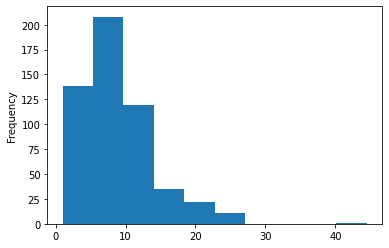

In [ ]:
# Plot the distribution in a simple histogram
wages_survey_raw.target.plot.hist()

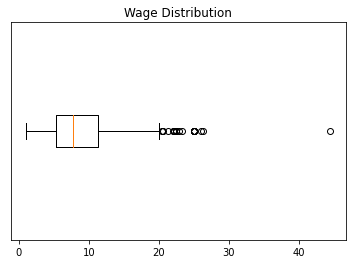

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution in a boxplot
fig1, ax1 = plt.subplots() # initialize plot
ax1.set_title('Wage Distribution') # add a plot title
ax1.boxplot(wages_survey_raw.target, vert=False) # add boxplot object
plt.yticks([]) # Remove y ticks
# display the plot
fig1.show()

There is one clear outlier in the dataset. Let's check his or hers data. Before we do this, we first combine the outcome (Wage) with our predictors.

In [ ]:
# create a "deep" copy of our predictor dataframe
wages_survey_X_copy = wages_survey_X.copy()
# add the outcome variable to the dataframe
wages_survey_X_copy.insert(0, "WAGE", wages_survey_y)

# Get outlier row by looking for the maximum WAGE row index
wages_survey_X_copy.iloc[wages_survey_X_copy['WAGE'].idxmax()]

# In case we would decide to remove that row from our dataset, we could use the following command:
# wages_survey_X_copy.drop(wages_survey_X_copy['WAGE'].idxmax(), axis=0, inplace=True)

WAGE                44.5
EDUCATION           14.0
SOUTH                 no
SEX               female
EXPERIENCE           1.0
UNION         not_member
AGE                 21.0
RACE               White
OCCUPATION    Management
SECTOR             Other
MARR           Unmarried
Name: 170, dtype: object

How are our continuous vairables correlated with each other? We can see this in a pairplot using the `seaborn` package:

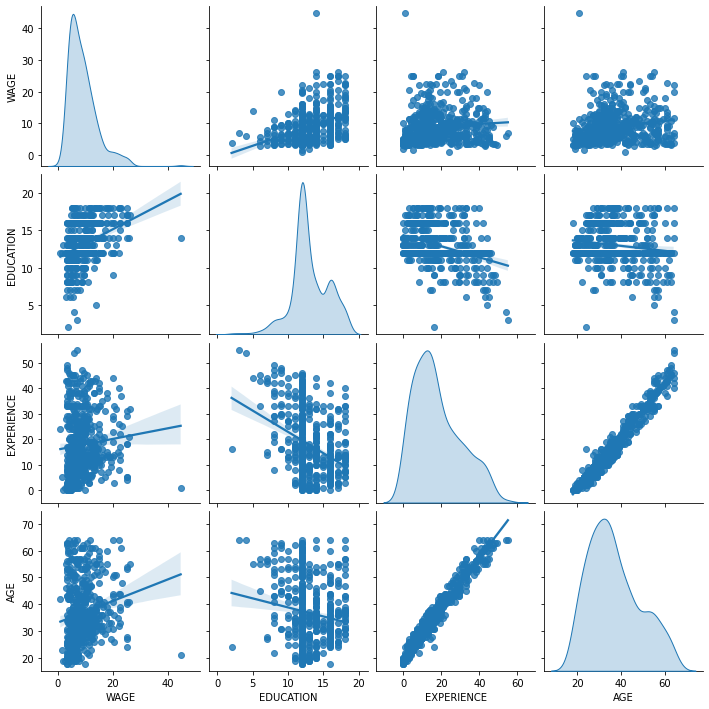

In [ ]:
# import all functions from the seaborn package and name it sns
import seaborn as sns

# create a "deep" copy of our predictor dataframe
wages_survey_X_copy = wages_survey_X.copy()
# add the outcome variable to the dataframe
wages_survey_X_copy.insert(0, "WAGE", wages_survey_y)
# plot the relationships of all continuous variables and their individual distributions
sns.pairplot(wages_survey_X_copy, kind="reg", diag_kind="kde")

What about our other predictors which are categorical?

* Sex
* South
* Race
* Sector
* Married

Let's also check the distributions for a selection of them and create a function to simplify the plot generation.

In [ ]:
def distribution_plot(column_name,
                      column_label,
                      ticks_label = None):
  # Group and count the data by category
  grouped_categeories = wages_survey_X.groupby(by=column_name, dropna=False).size()
  
  # Start the Plot procedure
  fig = plt.figure() # initialize plot
  ax = fig.add_axes(rect = [0,0,1,1]) # Add axes to plot
  ax.set_ylabel("Count") # add y label
  ax.set_xlabel(column_label) # add dynamic x label
  ax.set_title("Distribution of " + column_label) # add a plot title
  
  # if labels for ticks are provided, use them, otherwise use the default ones
  if ticks_label is None:
    ax.bar(x = list([str(i) for i in grouped_categeories.keys()]), height = grouped_categeories)
  else:
    ax.bar(x = ticks_label, height = grouped_categeories)
  # display the plot
  plt.show()

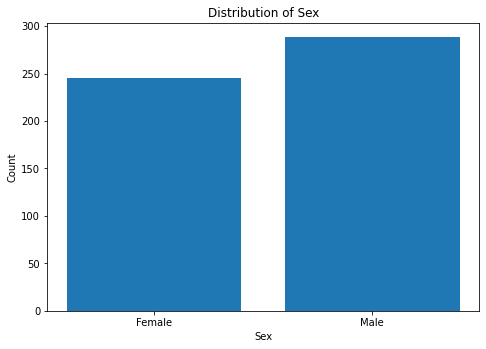

In [ ]:
distribution_plot("SEX", "Sex", ["Female", "Male"])

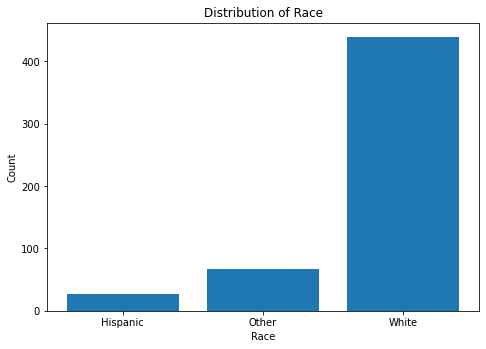

In [ ]:
distribution_plot("RACE", "Race")

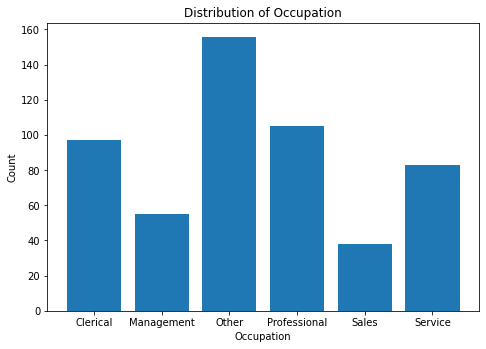

In [ ]:
distribution_plot("OCCUPATION", "Occupation")

To simplify our analysis we only include Education, Experience and Sex into our upcoming models. Let's just keep these columns by selecting them and do a final check for any NA values.

In [ ]:
# Select the columns we're focusing on
wages_survey_X = wages_survey_X[["SEX", "OCCUPATION", "MARR"]]

# Check these columns for NA values and print the result
print(f"Are there any NA values in the predictors? -> {wages_survey_X.isna().values.any()}")
# Also check our outcome variable wage for NA values and print the result
print(f"Are there any NA values in the outcome? -> {wages_survey_raw.target.isna().values.any()}")

Are there any NA values in the predictors? -> False
Are there any NA values in the outcome? -> False


Fortunately, we do not obsere any NA values in these columns. If you work with another dataset with NA values you could try to impute them. The Scikit-learn package offers great oppourtunities to start with: [Scikit-Learn Data Imputation](https://scikit-learn.org/stable/modules/impute.html)

### 2 Preprocessing

Let's continue with some basic preprocessing steps and a train-/testsplit for the upcoming models.

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
# Show no warnings
pd.options.mode.chained_assignment = None

le = LabelEncoder() # functionality to replace categorie names of a feature with numerical IDs
wages_survey_X["SEX"] = le.fit_transform(wages_survey_X["SEX"])
wages_survey_X["OCCUPATION"] = le.fit_transform(wages_survey_X["OCCUPATION"])
wages_survey_X["MARR"] = le.fit_transform(wages_survey_X["MARR"])

In [ ]:
import pandas as pd

# Cut the dataset into two portions and adjust the outcome variable accordingly
# Less than wage mean = 0, more than wage mean = 1
wages_survey_y = pd.cut(wages_survey_raw.target, [0, wages_survey_raw.target.mean(), wages_survey_raw.target.max()], labels = ["0", "1"])
wages_survey_y

0      0
1      0
2      0
3      0
4      0
      ..
529    1
530    0
531    1
532    1
533    1
Name: WAGE, Length: 534, dtype: category
Categories (2, object): ['0' < '1']

In [ ]:
wages_survey_X

,SEX,OCCUPATION,MARR
0,0,2,0
1,0,2,0
2,1,2,1
3,1,2,1
4,1,2,0
...,...,...,...
529,1,3,1
530,0,3,0
531,0,3,0
532,1,3,0


In [ ]:
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV, RandomizedSearchCV

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    wages_survey_X, wages_survey_y, test_size=0.2, random_state=20221216)

Let's take a look at the train data set:

In [ ]:
X_train

,SEX,OCCUPATION,MARR
280,1,0,0
487,0,3,1
317,0,0,0
52,0,2,0
163,1,1,1
...,...,...,...
523,1,3,0
422,0,5,0
10,1,2,0
145,1,2,0


In [ ]:
y_train

280    0
487    0
317    1
52     0
163    0
      ..
523    0
422    0
10     1
145    0
240    0
Name: WAGE, Length: 427, dtype: category
Categories (2, object): ['0' < '1']

### 3 Logistic Regression in Python

Our first model we apply is a simple Logistic Regression. As we focus on prediction we don't care about coefficients as we normally would know it from R. We use our train- and testset to fit our classifier on and afterwards use our trained model to predict on an out-of-sample. We can evaluate our results with a widely-used metric called F1 Score.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Train classifier with default parameters
clf = LogisticRegression(random_state=20230201)
clf.fit(X_train, y_train) # adapt the logistic regression algorithm to our training data

# Predict on test set
y_pred = clf.predict(X_test) # do an out-of-sample prediction on the test set using our trained classifier

# Print results
print("F1 score:", f1_score(y_test, y_pred, average="weighted"))

F1 score: 0.6115972766717637


This is our first result on a Logistic Regression using default parameters. The following function gives us this default setting:

In [ ]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

As we want to optimize our model to get better results, we should always try to tune its so-called hyperparameters. We define a range of suitable parameters and run a grid search to estimate the best parameter on our data.

In [ ]:
import numpy as np

# Generate integers spaced evenly on a log scale with base 1.5
C = list(set(np.logspace(1, 20, base=1.5, dtype='int')))
print(f"C: {C}")

param_grid = [
  {'C': C,
   'class_weight': ["balanced", None],
   'solver': ['newton-cg', 'lbfgs', 'liblinear']
   }]

C: [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 268, 13, 1294, 15, 143, 18, 21, 25, 2074, 2841, 29, 34, 167, 40, 807, 430, 47, 945, 690, 55, 314, 65, 196, 76, 589, 1106, 89, 229, 104, 1515, 1772, 368, 504, 122, 2428, 3325]


In [ ]:
# Set up Random Grid Search
grid = RandomizedSearchCV(LogisticRegression(random_state=20230201), 
                          param_distributions = param_grid, 
                          n_iter=100, 
                          verbose=1,
                          cv=5,
                          random_state=20230201, 
                          refit=True,
                          n_jobs=-1)

# Save results in dataframe
results = grid.fit(X_train, y_train)

# Print best params
print(grid.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'solver': 'lbfgs', 'class_weight': None, 'C': 6}


Using the best model fitted on the hyperparameters above we can do another prediction on the unseen testset and calculate our new F1 Score:

In [ ]:
# Predict with best model
y_pred = results.best_estimator_.predict(X_test) # do an out-of-sample prediction on the test set using our tuned classifier

# Print results
print("F1 score:", f1_score(y_test, y_pred, average="weighted"))

F1 score: 0.6115972766717637


It seems that this did not increase our performance. There are cases were the default parameters are already the best choice - but there exist also cases were tuning produces significant better models!

### 4 Random Forest in Python

When applying machine learning we always should try out different models. Hence, we use a Random Forest model as a second classifier. You already know the upcoming steps:


1.   Select and initialize the model
2.   Check performance of the model with default hyperparameters
3.   Define Hyperparameter ranges
4.   Run Grid Search
5.   Compare results of both models (tuned and untuned)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Train classifier with default parameters
clf = RandomForestClassifier(random_state=20220725)
clf.fit(X_train, y_train) # adapt the random forest algorithm to our training data

# Predict on test set
y_pred = clf.predict(X_test) # do an out-of-sample prediction on the test set using our trained classifier

# Print results
print("F1 score:", f1_score(y_test, y_pred, average="weighted"))

F1 score: 0.6716753772646388


In [ ]:
import random as random
import pandas as pd

# Generate 50 random integers between 1 and 1000 and add them to the n_est list
n_est = []
[n_est.append(random.randint(1, 1000)) for i in range(0, 50)]
print(f"n_est: {n_est}")

# Generate 50 random integers between 1 and 100 and add them to the max_depth list
max_depth = []
[max_depth.append(random.randint(1, 100)) for i in range(0, 50)]
print(f"max_depth: {max_depth}")

# Set up paramater grid to tune with (data type: dictionary)
param_grid = [
  {'bootstrap': [True, False],
  'max_features': ['auto', 'sqrt'],
   'min_samples_leaf': [1, 2, 4],
   'min_samples_split': [2, 5, 10],
   'n_estimators': list(set(n_est)),
   'criterion': ["gini", "entropy"],
   'max_depth': list(set(max_depth)) + [None],
   'class_weight': ["balanced", None]}
  ]

n_est: [402, 113, 350, 806, 995, 686, 664, 138, 567, 81, 953, 708, 472, 342, 628, 514, 743, 384, 973, 289, 204, 49, 957, 472, 400, 404, 530, 951, 646, 285, 655, 70, 744, 787, 116, 387, 583, 422, 545, 678, 332, 134, 912, 848, 428, 111, 270, 267, 689, 829].
max_depth: [39, 58, 83, 83, 88, 59, 94, 66, 71, 26, 62, 33, 73, 37, 72, 29, 30, 37, 83, 3, 5, 59, 37, 99, 74, 92, 93, 71, 3, 69, 53, 45, 31, 59, 92, 100, 42, 2, 68, 34, 43, 33, 16, 42, 26, 38, 86, 75, 3, 66].


In [ ]:
# Set up Random Grid Search
grid = RandomizedSearchCV(RandomForestClassifier(), 
                          param_distributions = param_grid, 
                          n_iter=100, 
                          verbose=1,
                          cv=5,
                          random_state=20230201, 
                          refit=True,
                          n_jobs=-1)

# Save results in dataframe
results = grid.fit(X_train, y_train)

# Print best params
print(grid.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'n_estimators': 920, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 79, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': False}


In [ ]:
# Predict with best model
y_pred = results.best_estimator_.predict(X_test)

# Print results
print("F1 score:", f1_score(y_test, y_pred, average="weighted"))

F1 score: 0.7372154325425354


The F1 Scores of both Random Forest models highlight two main takeaways: First, the hyperparameter tuning was quite fruitul for the Random Forest case. Second, a Random Forest seems to be more useful for prediction on this dataset than a Logistic Regression.

As we stick to the Random Forest, lets check what the importance of each feature for the model is. This can easily be achieved as follows:

In [ ]:
pd.DataFrame({"Feature": X_test.columns,
              "Importance": results.best_estimator_.feature_importances_}).sort_values('Importance', ascending=False)

,Feature,Importance
1,OCCUPATION,0.781869
0,SEX,0.117869
2,MARR,0.100261


Occupation has the highest importance, followed by sex and whether someone is married or not. But you should be cautious: These values cannot be directly used for further interpretation as you probably would tend to do with a OLS regression model in R. It gives a general indication of how the model made a decision.

### 5 Conclusion

This notebook shows how to apply frequently used packages and their function on a familiar data environment. We focused on some visualisation, pre-precessing of data and different classification algorithms in Python.

Let's conclude with a short outlook:
1. As you already know from similar packages in R such as dplyr or purrr, there are many more functionalities coming with `pandas`. A useful cheatsheet of the package can be found here: [Pandas Cheatsheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)
2. `scikit-learn` offers many more algorithms and ways to evaulate and configure regression and classification models. A great overview can be found on their Website: [How to choose the right estimator?](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
3. Beyond `scikit-learn` you should also consider `TensorFlow` or `PyTorch` for applying Deep Learning algorithms in Python. For the first you find a bunch of tutorials on their official [Website](https://www.tensorflow.org/tutorials), the latter comes with a great [YouTube Series](https://pytorch.org/tutorials/beginner/introyt.html) and hands-on Google Colab Notebooks
4. Most important: Python is not only about Machine Learning. It can do much more from creating fancy dashboards using [`Plotly`](https://plotly.com/dash) to sophisicated analysis based on extremley large (unstructured) data sources (e.g. with [`Dask`](https://www.dask.org/) or [`PySpark`](https://spark.apache.org/docs/latest/api/python/))

Thank you very much for joining Day 2 of the Python for Social Scientists Workshop!